<center>
    <h2>
        <font color = 'grey'> Grupo de Estudos Críticos em Infraestruturas Digitais, Artes e Inteligência Artificial </font>
    </h2>
    <h1>
        Exploring results on Google Translate experiment
    </h1>
    <h3>
        Author: 
        <font color = 'green'> Lucas Nunes Sequeira </font>
    </h3>
</center>

<h4>
    <font color = 'grey'> date: 05/10/2019 </font>
</h4>
    

<img src="results/front.png" alt="">

## Importing libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#sns.set()
%matplotlib inline

In [2]:
# Google Bilingual Evaluation Understudy
import nltk.translate.gleu_score as gleu

In [3]:
# To read files from our translation chain results
import json

In [4]:
from sklearn.linear_model import LinearRegression

## Functions

In [5]:
def read_json(filepath, psize = 1):
    '''
    
    Produces a pandas.DataFrame.
    
    Parameters:
    -----------
        filepath : string
            A string that represent the local path for json file.
            
    '''
    # read file
    file = open(filepath, 'r')
    aux_base = json.load(file)
    keys = aux_base[0].keys()
    for i, key in enumerate(keys):
        
        # starts the DataFrame
        if i == 0:
            temp = []
            size = int(psize * len(aux_base))
            for j in range(size):
                temp.append(aux_base[j][key])
            base = pd.DataFrame({key: temp})
            
        # append to DataFrame
        else:
            temp = []
            size = int(psize * len(aux_base))
            for j in range(size):
                temp.append(aux_base[j][key])
            base[key] = temp
            
    file.close()
    
    # returns the pd.DataFrame with an adition of 2 columns, 'From code' and 'From lang'.
    return FromCodeLang(base)

In [6]:
def FromCodeLang(data):
    '''
    
    Recieve a pandas.DataFrame and add to it 2 new columns, 'From code' and 'To code' according to the previews codes and corresponding languages for each row in the pandas.DataFrame.
    
    Parameters:
    -----------
        data : pandas.DataFrame
            A pandas.DataFrame that contains columns 'Code' and 'Language'.
            
    '''
    
    # collect code and languages
    codes = data['Code'].values
    langs = data['Language'].values
    
    from_codes = []
    from_langs = []
    
    # append the previews code and language for each row
    for i in range(len(codes)-1):
        from_codes.append(codes[i])
        from_langs.append(langs[i])
        
    # for the first language of the chain, repeat it self
    from_codes.insert(0, codes[0])
    from_langs.insert(0,langs[0])
    
    # add to pd.DataFrame
    data['From code'] = from_codes
    data['From lang'] = from_langs
    data.rename(columns = {'Language': 'Lang', 'Code': 'Code', 'Text_origin': 'Text origin', 'Text_en': 'Text en'}, inplace = True)
    return data

In [7]:
def RMSE(y, y_):
    '''
    
    Returns root mean square error
    
    '''
    
    return np.sqrt(((y-y_)**2).sum()/len(y))

In [8]:
def meanCorr(corr, mid = False):
    '''
    
    Returns the mean value for matrix.
    
    Parameters:
    -----------
        corr : pd.DataFrame
            pd.DataFrame with shape (n, m)
        mid : boolean
            If True, the function will exclude the pairs of repeated language.
    
    '''
    mean = corr.sum().sum()
    if mid == False:
        k = len(corr.columns)
    else:
        k = 0
    mean -= k
    mean /= (len(corr.columns) * len(corr.index) - k)
    
    return mean

In [68]:
def prepareCorr(corr, name = 'from \ to', dropEnglish = True):
    '''
    
    Returns a pd.DataFrame with index name set to be 'name' and drop or not English column
    
    Parameters:
    -----------
        corr : pd.DataFrame
            pd.DataFrame with shape (n, m)
        name : string
            name for the index
        dropEnglish : boolean
            If True, the function will exclude the English column.
    
    '''
    if dropEnglish == True:
        try:
            temp = corr.drop('English', axis = 1).reset_index()
        except:
            try:
                temp = corr.drop('English', axis = 0).reset_index()
            except:
                print('ERRO! English not in axis')
                return
    else:
        temp = corr.reset_index()
    temp = temp.rename({'from \ to': name}, axis = 1)
    temp = temp.set_index(name)
    return temp.copy()

## Classes

In [10]:
class Result:
    '''
    
    Create a Result class, that have some cool stuf built especific, as plots.
    
    Parameters:
    -----------
        filepath : string
            A string that represent the local path for json file.
        n : uint
            Especify the first n rows of pd.DataFrame to read.
        graphpap : boolean
            If True, it create a correlation matrix with corresponding gleu score for each translation pair.
        
    Atributes:
    -----------
        df_ : pd.DataFrame
            The pd.DataFrame read from results.
        sz_ : int
            The size of df_
        graph_pap_ : pd.DataFrame
            Correlation matrix of gleu score of each pair of language
        self.acc_harmonic_ : array
            The theorical curve that aproximates to GLEU acc empirichal results
        self.acc_alpha_ : float
            The divergence factor which describes acc_harmonic_
        self.acc_erro_ : array
            RMSE for each t between GLEU acc and acc_harmonic_
        self.sz_harmonic_ : array
            The theorical curve that aproximates to sz empirichal results
        self.sz_alpha_ : float
            The divergence factor which describes sz_harmonic_
        self.sz_erro_ : array
            RMSE for each t between size and sz_harmonic_
            
    '''
    
    def __init__(self, filepath, n = None, graphpap = False, psize = 1):
        self.df_ = read_json(filepath, psize = psize)
        if n is not None:
            self.df_ = self.df_.head(n)
        self.sz_ = len(self.df_)
        self.graph_pap_ = None
        self.acc_harmonic_ = None
        self.sz_harmonic_ = None
        self.acc_alpha_ = None
        self.sz_alpha_ = None
        self.acc_erro_ = None
        self.sz_erro_ = None
        self.prepare(graphpap)
        
    def getPair(self, fromV, toV, kind = 'Code'):
        '''
    
        Return a pd.DataFrame that have all the pair of 'from value' and 'to value', wich value can be 'language' or 'code'.

        Parameters:
        -----------
            fromV : string
                A string that represent the 'from value'.
            toV : string
                A string that represent the 'to value'.
            kind : string
                especify the kind of value. Can be 'Code' or 'Lang'.
           
        '''
        if kind == 'Code':
            temp = self.df_[self.df_['From code'] == fromV]
            return temp[temp['Code'] == toV]
        else:
            temp = self.df_[self.df_['From lang'] == fromV]
            return temp[temp['Lang'] == toV]
        
    def addGLEUacc(self):
        '''
    
        Adds to df_ a 'GLEU acc' column that contains the acumulative score, by comparing each english version of the translation chain with the original text also in english.

           
        '''
        # original text in english as reference
        reference = self.df_['Text en'][0]
        
        # first score set to be 1.0 (comparing same languages)
        temp = [1.0]
        for hypothesis in self.df_['Text en'][1:]:
            
            # take the gleu score
            gleu_value = gleu.sentence_gleu([reference], hypothesis)
            
            temp.append(gleu_value)
        
        # add to df_
        self.df_['GLEU acc'] = temp
        
        del temp
        
    def addGLEUpap(self):
        '''
    
        Adds to df_ a 'GLEU pap' column that contains the step to step score, by comparing each english version of the translation chain with the previews text also in english.

           
        '''
        # first reference
        reference = self.df_['Text en'][0]
        
        # first score set to be 1.0 (comparing same languages)
        temp = [1.0]
        for i, hypothesis in enumerate(self.df_['Text en'][1:]):
            # take the gleu score
            gleu_value = gleu.sentence_gleu([reference], hypothesis)
            temp.append(gleu_value)
            
            # change reference
            reference = hypothesis
        self.df_['GLEU pap'] = temp
        del temp
        
    def addSizes(self):
        '''
        
        Adds to df_ a 'Size' column that contains for each text in english, it word count.
        
        '''
        self.df_['Size'] = self.df_['Text en'].apply(lambda x : len(x.split()))
    
    def addHarmonic(self):
        '''
        
        Calculates the best harmonic function for Size and GLEU acc my minimizing RMSE. Also record the alpha used for each case, and the RMSE.
        
        '''
        # calculating for GLEU acc
        best_alpha = 0
        best_erro = 999999999
        scores = self.df_['GLEU acc']
        x = np.arange(len(scores))
        
        # finding minimum error
        for alpha in np.linspace(0,5,500):
            y = (x+1)**(-alpha)
            erro = RMSE(y, scores)
            if erro < best_erro:
                best_erro = erro
                best_alpha = alpha
                
        self.acc_harmonic_ = (x+1)**(-best_alpha)
        self.acc_alpha_ = best_alpha
        self.acc_erro_ = best_erro
        
        # calculating for Size
        best_alpha = 0
        best_erro = 999999999
        scores = self.df_['Size']
        x = np.arange(len(scores))
        
        # finding minimum error
        for alpha in np.linspace(0,5,500):
            y = scores[0]*(x+1)**(-alpha)
            erro = RMSE(y, scores)
            if erro < best_erro:
                best_erro = erro
                best_alpha = alpha
                
        self.sz_harmonic_ = scores[0]*(x+1)**(-best_alpha)
        self.sz_alpha_ = best_alpha
        self.sz_erro_ = best_erro
        
        
        
    def graphGLEUpap(self):
        '''
        
        Constructs a directioned graph as a matrix of GLEU step by step (pap) for each pair of language
        
        '''
        
        temp = {'from \ to': self.df_['Lang'].unique()}
        temp = pd.DataFrame(temp)
        for lang in self.df_['Lang'].unique():
            aux = pd.DataFrame({lang : temp['from \ to'].apply(lambda x : self.getPair(x, lang, kind = 'Lang')['GLEU pap'].mean())})
            temp = pd.concat([temp, aux], axis = 1)
        self.graph_pap_ = temp.set_index('from \ to', drop = True)
        for lang in self.df_['Lang'].unique():
            self.graph_pap_.loc[lang][lang] = 1.0
        del temp
        
    def prepare(self, graphpap):
        '''
        
        Prepare the object performing some methods as addGLEUacc, addGLEUpap, addSizes, addHarmonic and graphGLEUpap.
        
        Parameters:
        -----------
            graphpap: boolean
                if True, the method perform graphGLEUpap()
        
        '''
        
        self.addGLEUacc()
        self.addGLEUpap()
        self.addSizes()
        self.addHarmonic()
        if graphpap:
            self.graphGLEUpap()

In [37]:
class Results:
    
    def __init__(self, results = None, names = None, graphpap = False):
        self.res = {}
        if results is not None:
            for i in range(len(names)):
                self.addResult(results[i], names[i])
        self.graph_pap_ = None
        self.acc_mean_ = None
        self.acc_harmonic_ = None
        self.acc_alpha_ = None
        self.acc_erro_ = None
        self.sz_mean_ = None
        self.sz_harmonic_ = None
        self.sz_alpha_ = None
        self.sz_erro_ = None
        self.prepare(graphpap)
        
        
    def addResult(self, result, name):
        self.res[name] = result
        
    def addHarmonic(self):
        best_alpha = 0
        best_erro = 999999999
        scores = self.acc_mean_
        x = np.arange(len(scores))
        for alpha in np.linspace(0,5,500):
            y = (x+1)**(-alpha)
            erro = RMSE(y, scores)
            if erro < best_erro:
                best_erro = erro
                best_alpha = alpha
        self.acc_harmonic_ = (x+1)**(-best_alpha)
        self.acc_alpha_ = best_alpha
        self.acc_erro_ = best_erro
        
        best_alpha = 0
        best_erro = 999999999
        scores = self.sz_mean_
        x = np.arange(len(scores))
        for alpha in np.linspace(0,5,500):
            y = scores[0]*(x+1)**(-alpha)
            erro = RMSE(y, scores)
            if erro < best_erro:
                best_erro = erro
                best_alpha = alpha
        self.sz_harmonic_ = scores[0]*(x+1)**(-best_alpha)
        self.sz_alpha_ = best_alpha
        self.sz_erro_ = best_erro
        
    def prepare(self, pap):
        if pap:
            self.graphGLEUpap()
            
        # gleu acc mean; and sz mean
        n = self.res[list(self.res.keys())[0]].sz_
        self.acc_mean_ = np.zeros(n)
        self.sz_mean_ = np.zeros(n)
        
        for name in self.res.keys():
            self.acc_mean_ += self.res[name].df_['GLEU acc']
            self.sz_mean_ += self.res[name].df_['Size']
            
        self.acc_mean_ /= len(self.res.keys())
        self.acc_mean_ = self.acc_mean_.values
        
        self.sz_mean_ /= len(self.res.keys())
        self.sz_mean_ = self.sz_mean_.values
        
        # addHarmonic
        
        self.addHarmonic()
        
    def graphGLEUpap(self):
        print(self.res.keys())
        self.graph_pap_ = self.res[list(self.res.keys())[0]].graph_pap_.copy()
        for flang in self.graph_pap_.index:
            for tlang in self.graph_pap_.index:
                temp = []
                count = 0
                for name in self.res.keys():
                    value = self.res[name].graph_pap_.loc[flang][tlang]
                    if not np.isnan(value):
                        temp.append(value)
                        count += 1
                if count == 0:
                    temp = np.nan
                    self.graph_pap_.loc[flang][tlang] = temp
                else:
                    temp = np.array(temp).mean()
                    self.graph_pap_.loc[flang][tlang] = temp/count
        
    
    def plot(self, by, lw = 3, showAll = True, showMean = True,
             fillBetween = False, showHarmonic = False, ylabel = 'score',
             title = None, alphaAll = 0.5, ymin = None, ymax=None):
        plt.figure(figsize=(14,8))
        
        if title == None:
            title = by
        
        # mean
        mean = None
        if by == 'GLEU acc':
            mean = self.acc_mean_
            rmse = RMSE(mean, self.acc_harmonic_)
        if by == 'Size':
            mean = self.sz_mean_
            rmse = RMSE(mean, self.sz_harmonic_)
            
            
        n = self.res[list(self.res.keys())[0]].sz_
        erro = np.zeros(n)
        for name in self.res.keys():
            if showAll:
                plt.plot(self.res[name].df_[by], lw = lw, label = name, alpha = alphaAll)
                
        if fillBetween:
            for name in self.res.keys():
                erro += (self.res[name].df_[by].values - mean)**2
            erro /= len(self.res.keys())
            erro = np.sqrt(erro)
            x = np.arange(n)
            plt.fill_between(x, mean, mean + erro, color = 'firebrick', alpha = 0.5, label = 'mean confiance')
            plt.fill_between(x, mean, mean - erro, color = 'firebrick', alpha = 0.5)
            if not showMean and showHarmonic:
                print('>> RMSE:', rmse)
            
        if showMean:
            plt.plot(mean, '-', lw = 3, label = 'mean', color = 'red')
            if showHarmonic:
                print('>> RMSE:', rmse)
        if showHarmonic:
            if by == 'GLEU acc':
                print('>> alpha: {0:1.5f}'.format(self.acc_alpha_))
                plt.plot(self.acc_harmonic_, '--', lw = lw, label = 'AEL', color = 'navy')
            else:
                print('>> alpha: {0:1.5f}'.format(self.sz_alpha_))
                plt.plot(self.sz_harmonic_, '--', lw = lw, label = 'AEL', color = 'navy')
        
        if ymin and ymax:
            plt.ylim((ymin, ymax))
        plt.title(title, fontsize = 22)
        plt.xlabel('# translation', fontsize = 18)
        plt.ylabel(ylabel, fontsize = 18)
        plt.legend(fontsize = 15)
        plt.rc('xtick', labelsize=14)
        plt.rc('ytick', labelsize=14)
        plt.grid(axis = 'both', linestyle='--', lw = 0.5)
        
        return mean
    
    def plotRegression(self, by, lw = 3):
        plt.figure(figsize=(14,8))
        x = np.arange(len(self.acc_harmonic_), dtype = float)
        if by == 'GLEU acc':
            print('>> alpha:', self.acc_alpha_)
            mean_ = self.acc_mean_*(x)**(self.acc_alpha_+1)
        else:
            print('>> alpha:', self.sz_alpha_)
            mean_ = self.sz_mean_*(x)**(self.sz_alpha_+1)
        reg = LinearRegression()
        reg.fit(x.reshape(-1,1), mean_)
        print('>> R-squared:', reg.score(x.reshape(-1,1), mean_.reshape(-1,1)))
        y = reg.predict(x.reshape(-1,1))
        plt.plot(mean_, lw = lw, label = 'linear mean', color = 'red')
        plt.plot(y, '--', lw = lw, label = 'linear AEL', color = 'navy')            
        plt.title('GLEU accumulated in linear approach', fontsize = 20)
        plt.xlabel(r'# translation', fontsize = 18)
        plt.ylabel('linear score', fontsize = 18)
        plt.legend(fontsize = 15)
        plt.rc('xtick', labelsize=14)
        plt.rc('ytick', labelsize=14)
        plt.grid(axis = 'both', linestyle='--', lw = 0.5)


        return mean
    
    def plotLogLog(self, by, lw = 1, ms = 5):
        plt.figure(figsize=(14,8))
        if by == 'GLEU acc':
            plt.loglog(self.acc_mean_, 'o--', lw = lw, color = 'purple', label = 'mean', markersize = ms, markerfacecolor = 'deeppink')
        if by == 'Size':
            plt.loglog(self.sz_mean_, 'o--', lw = lw, color = 'purple', label = 'mean', markersize = ms, markerfacecolor = 'deeppink')
        plt.title(by+' | loglog Visualization', fontsize = 20)
        plt.xlabel(r'$\log$ translation $[\log(t)]$', fontsize = 16)
        plt.ylabel(r'$\log$ mean', fontsize = 16)
        plt.legend(fontsize = 13)
        plt.rc('xtick', labelsize=14)
        plt.rc('ytick', labelsize=14)
        plt.grid(axis = 'both', linestyle='--', lw = 0.5)

## Exploring b1, b2, b3, t1, t2 experiments

In [38]:
rand1_t1 = Result('results/rand1_t1.json')
rand1_t2 = Result('results/rand1_t2.json')
rand1_t3 = Result('results/rand1_t3.json')
rand1_t4 = Result('results/rand1_t4.json')
rand2_t1 = Result('results/rand2_t1.json')
rand2_t2 = Result('results/rand2_t2.json')
rand2_t3 = Result('results/rand2_t3.json')
rand2_t4 = Result('results/rand2_t4.json')
rand3_t1 = Result('results/rand3_t1.json')
rand3_t2 = Result('results/rand3_t2.json')
rand3_t3 = Result('results/rand3_t3.json')
rand3_t4 = Result('results/rand3_t4.json')

results = [rand1_t1, rand2_t1, rand3_t1, rand1_t2, rand2_t2, rand3_t2, rand1_t3, rand2_t3, rand3_t3, rand1_t4, rand2_t4, rand3_t4]
names = ['rand1_t1', 'rand2_t1', 'rand3_t1', 'rand1_t2', 'rand2_t2', 'rand3_t2', 'rand1_t3', 'rand2_t3', 'rand3_t3', 'rand1_t4', 'rand2_t4', 'rand3_t4']

res_all = Results(results, names)

###############################################################

results = [rand1_t1, rand2_t1, rand3_t1]
names = ['rand1_t1', 'rand2_t1', 'rand3_t1']

res_all_t1 = Results(results, names)

###############################################################

results = [rand1_t2, rand2_t2, rand3_t2]
names = ['rand1_t2', 'rand2_t2', 'rand3_t2']

res_all_t2 = Results(results, names)

###############################################################

results = [rand1_t3, rand2_t3, rand3_t3]
names = ['rand1_t3', 'rand2_t3', 'rand3_t3']

res_all_t3 = Results(results, names)

###############################################################

results = [rand1_t4, rand2_t4, rand3_t4]
names = ['rand1_t4', 'rand2_t4', 'rand3_t4']

res_all_t4 = Results(results, names)

###############################################################

results = [rand1_t1, rand2_t1, rand3_t1, rand1_t3, rand2_t3, rand3_t3]
names = ['rand1_t1', 'rand2_t1', 'rand3_t1', 'rand1_t3', 'rand2_t3', 'rand3_t3']

res_all_t1_t3 = Results(results, names)

###############################################################

results = [rand1_t2, rand2_t2, rand3_t2, rand1_t4, rand2_t4, rand3_t4]
names = ['rand1_t2', 'rand2_t2', 'rand3_t2', 'rand1_t4', 'rand2_t4', 'rand3_t4']

res_all_t2_t4 = Results(results, names)

###############################################################

psize = 0.05

rand1_t1 = Result('results/rand1_t1.json', psize = psize)
rand1_t2 = Result('results/rand1_t2.json', psize = psize)
rand1_t3 = Result('results/rand1_t3.json', psize = psize)
rand1_t4 = Result('results/rand1_t4.json', psize = psize)
rand2_t1 = Result('results/rand2_t1.json', psize = psize)
rand2_t2 = Result('results/rand2_t2.json', psize = psize)
rand2_t3 = Result('results/rand2_t3.json', psize = psize)
rand2_t4 = Result('results/rand2_t4.json', psize = psize)
rand3_t1 = Result('results/rand3_t1.json', psize = psize)
rand3_t2 = Result('results/rand3_t2.json', psize = psize)
rand3_t3 = Result('results/rand3_t3.json', psize = psize)
rand3_t4 = Result('results/rand3_t4.json', psize = psize)


results = [rand1_t1, rand2_t1, rand3_t1, rand1_t2, rand2_t2, rand3_t2, rand1_t3, rand2_t3, rand3_t3, rand1_t4, rand2_t4, rand3_t4]
names = ['rand1_t1', 'rand2_t1', 'rand3_t1', 'rand1_t2', 'rand2_t2', 'rand3_t2', 'rand1_t3', 'rand2_t3', 'rand3_t3', 'rand1_t4', 'rand2_t4', 'rand3_t4']

res_mid = Results(results, names)

################################################################

com1_t1 = Result('results/com1_t1.json')
com2_t1 = Result('results/com2_t1.json')
com1_t3 = Result('results/com1_t3.json')
com2_t3 = Result('results/com2_t3.json')

results = [com1_t1, com2_t1, com1_t3, com2_t3]
names = ['com1_t1', 'com2_t1', 'com1_t3', 'com2_t3']

resl_all = Results(results, names)

################################################################

com1_t1 = Result('results/com1_t1.json', psize = psize)
com2_t1 = Result('results/com2_t1.json', psize = psize)
com1_t3 = Result('results/com1_t3.json', psize = psize)
com2_t3 = Result('results/com2_t3.json', psize = psize)

results = [com1_t1, com2_t1, com1_t3, com2_t3]
names = ['com1_t1', 'com2_t1', 'com1_t3', 'com2_t3']

resl_mid = Results(results, names)

################################################################

mix1_t1 = Result('results/mix1_t1.json')
mix2_t1 = Result('results/mix2_t1.json')
mix1_t3 = Result('results/mix1_t3.json')
mix2_t3 = Result('results/mix2_t3.json')

results = [mix1_t1, mix2_t1, mix1_t3, mix2_t3]
names = ['mix1_t1', 'mix2_t1', 'mix1_t3', 'mix2_t3']
               
resr_all = Results(results, names)

mix1_t1 = Result('results/mix1_t1.json', psize = psize)
mix2_t1 = Result('results/mix2_t1.json', psize = psize)
mix1_t3 = Result('results/mix1_t3.json', psize = psize)
mix2_t3 = Result('results/mix2_t3.json', psize = psize)

results = [mix1_t1, mix2_t1, mix1_t3, mix2_t3]
names = ['mix1_t1', 'mix2_t1', 'mix1_t3', 'mix2_t3']
               
resr_mid = Results(results, names)

################################################################

com1_t1 = Result('results/com1_t1.json')
com2_t1 = Result('results/com2_t1.json')
mix1_t1 = Result('results/mix1_t1.json')
mix2_t1 = Result('results/mix2_t1.json')
com1_t3 = Result('results/com1_t3.json')
com2_t3 = Result('results/com2_t3.json')
mix1_t3 = Result('results/mix1_t3.json')
mix2_t3 = Result('results/mix2_t3.json')


results = [com1_t1, com2_t1, com1_t3, com2_t3, mix1_t1, mix2_t1, mix1_t3, mix2_t3]
names = ['com1_t1', 'com2_t1', 'com1_t3', 'com2_t3', 'mix1_t1', 'mix2_t1', 'mix1_t3', 'mix2_t3']
               
reslr_all = Results(results, names)

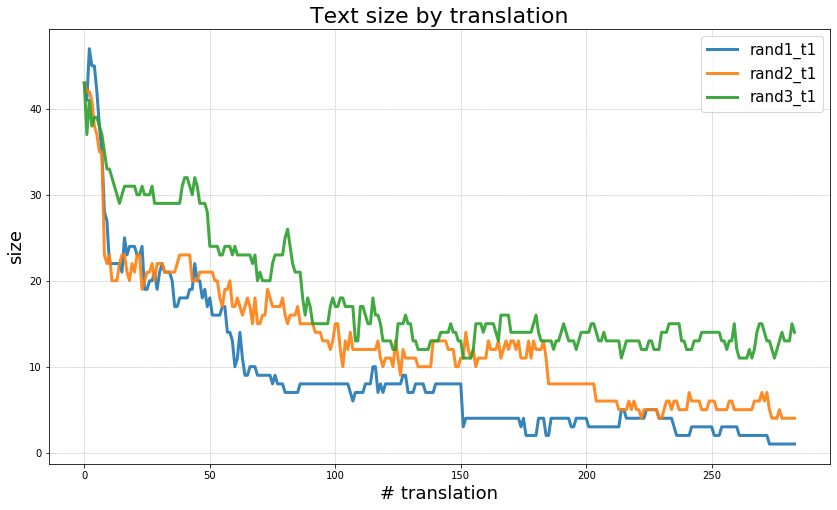

In [13]:
mean = res_all_t1.plot('Size', fillBetween=False, showAll = True, 
                       showMean = False, showHarmonic=False , alphaAll = 0.9, 
                       title = 'Text size by translation', ylabel = 'size')

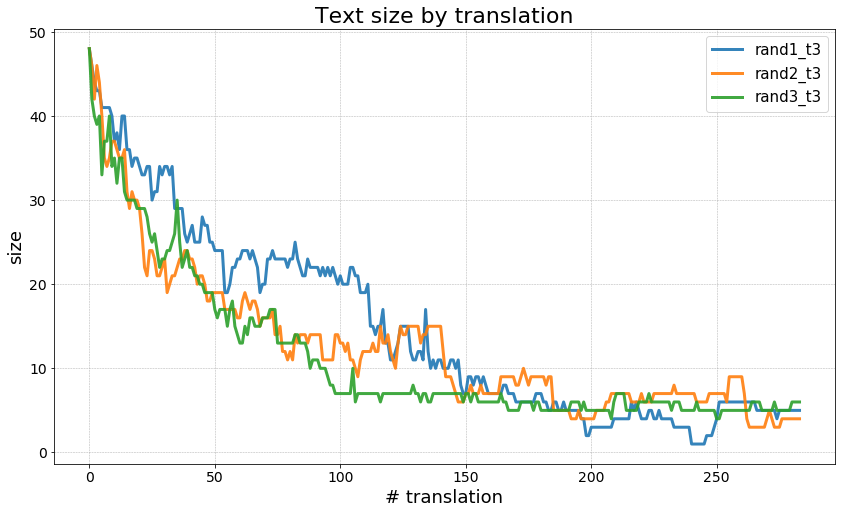

In [14]:
mean = res_all_t3.plot('Size', fillBetween=False, showAll = True, 
                       showMean = False, showHarmonic=False , alphaAll = 0.9, 
                       title = 'Text size by translation', ylabel = 'size')

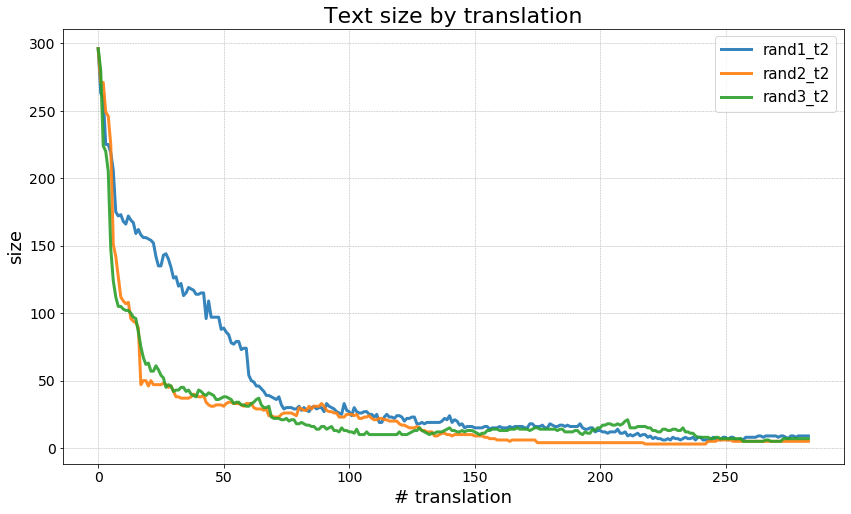

In [15]:
mean = res_all_t2.plot('Size', fillBetween=False, showAll = True, 
                       showMean = False, showHarmonic=False , alphaAll = 0.9, 
                       title = 'Text size by translation', ylabel = 'size')

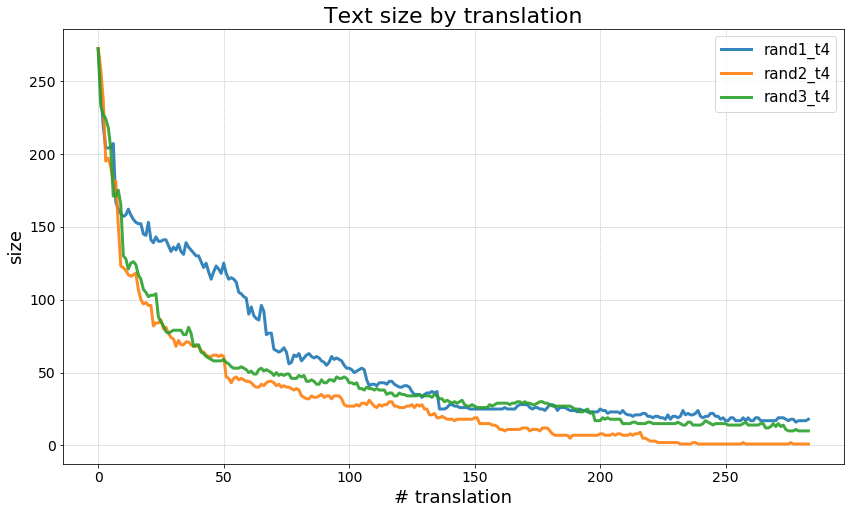

In [16]:
mean = res_all_t4.plot('Size', fillBetween=False, showAll = True, 
                       showMean = False, showHarmonic=False , alphaAll = 0.9, 
                       title = 'Text size by translation', ylabel = 'size')

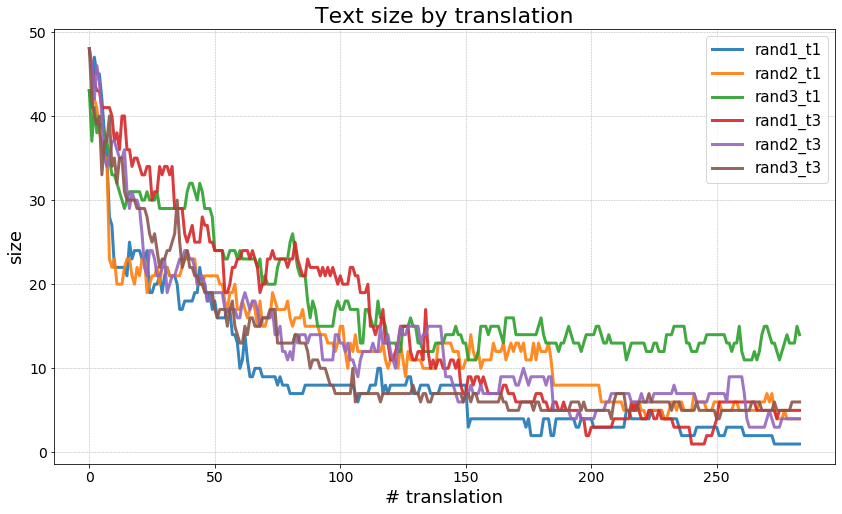

In [29]:
mean = res_all_t1_t3.plot('Size', fillBetween=False, showAll = True, 
                       showMean = False, showHarmonic=False , alphaAll = 0.9, 
                       title = 'Text size by translation', ylabel = 'size')

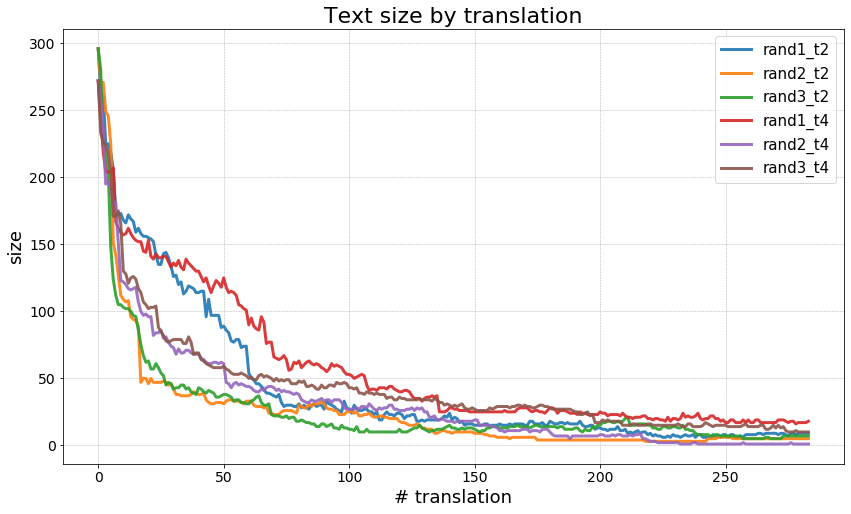

In [34]:
mean = res_all_t2_t4.plot('Size', fillBetween=False, showAll = True, 
                       showMean = False, showHarmonic=False , alphaAll = 0.9, 
                       title = 'Text size by translation', ylabel = 'size')

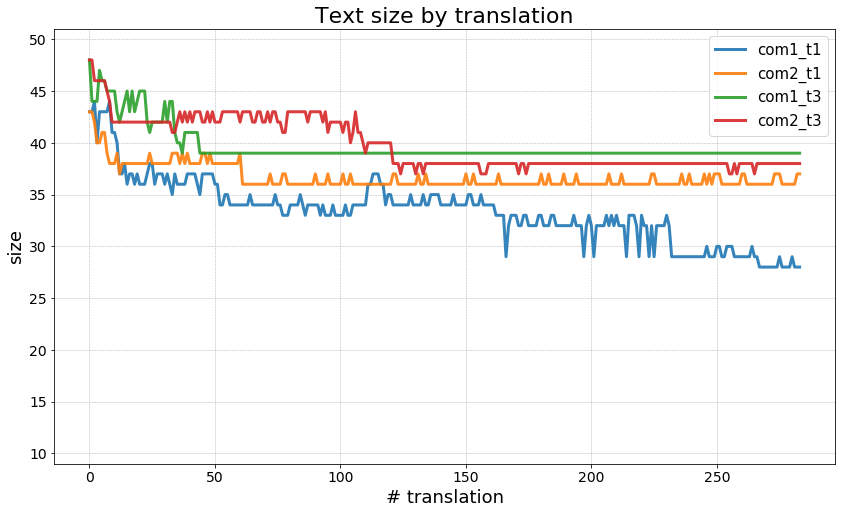

In [41]:
mean = resl_all.plot('Size', fillBetween=False, showAll = True, 
                      showMean = False,showHarmonic=False , 
                      alphaAll = 0.9, title = 'Text size by translation', ylabel = 'size', ymin = 9, ymax=51)

In [42]:
mean

array([45.5 , 44.5 , 44.  , 42.5 , 44.  , 44.  , 44.  , 43.  , 42.75,
       41.5 , 41.5 , 41.  , 39.5 , 40.  , 40.5 , 40.25, 40.  , 40.5 ,
       39.75, 40.25, 40.25, 40.25, 40.25, 39.75, 40.  , 40.  , 39.5 ,
       39.75, 39.75, 39.75, 40.  , 39.75, 40.  , 39.75, 39.5 , 39.25,
       39.25, 39.  , 39.5 , 39.75, 39.75, 39.5 , 39.75, 39.5 , 38.75,
       39.25, 39.25, 39.25, 39.25, 39.25, 38.75, 38.75, 38.25, 38.5 ,
       38.75, 38.75, 38.5 , 38.5 , 38.5 , 38.5 , 38.5 , 38.  , 38.  ,
       38.  , 38.25, 37.75, 37.75, 38.  , 38.  , 37.75, 37.75, 38.  ,
       38.  , 38.  , 38.25, 37.75, 37.75, 37.5 , 37.5 , 37.75, 38.  ,
       38.  , 38.  , 38.  , 38.25, 38.  , 37.75, 37.75, 38.  , 38.  ,
       38.25, 38.  , 37.75, 37.75, 37.75, 37.5 , 37.5 , 37.75, 37.5 ,
       37.5 , 37.5 , 37.5 , 37.75, 37.5 , 37.25, 37.5 , 38.  , 37.5 ,
       37.5 , 37.25, 37.  , 37.75, 37.75, 38.  , 38.  , 38.  , 37.75,
       37.75, 37.25, 37.5 , 37.5 , 37.  , 37.  , 36.75, 36.5 , 36.75,
       36.75, 36.75,

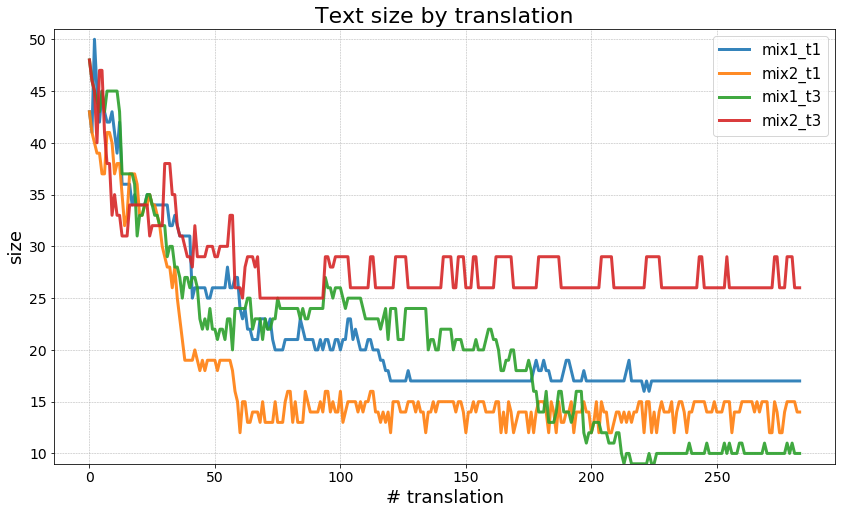

In [43]:
mean = resr_all.plot('Size', fillBetween=False, showAll = True, 
                      showMean = False,showHarmonic=False , 
                      alphaAll = 0.9, title = 'Text size by translation', ylabel = 'size', ymin = 9, ymax=51)

In [44]:
mean

array([45.5 , 43.5 , 45.  , 42.  , 42.75, 43.5 , 41.  , 41.5 , 41.5 ,
       40.25, 39.5 , 38.75, 39.  , 34.75, 34.  , 34.25, 36.  , 35.5 ,
       35.5 , 33.75, 33.5 , 33.5 , 34.  , 34.5 , 34.  , 33.5 , 33.25,
       33.  , 32.5 , 32.  , 33.25, 32.25, 32.  , 30.75, 31.  , 29.25,
       28.  , 27.  , 26.75, 26.5 , 26.25, 24.75, 26.25, 25.  , 24.  ,
       24.  , 24.  , 24.  , 24.5 , 24.25, 24.  , 23.5 , 24.25, 24.25,
       24.  , 25.  , 25.25, 24.25, 23.25, 23.  , 21.5 , 21.75, 22.75,
       22.25, 22.25, 21.5 , 21.5 , 21.75, 21.  , 21.  , 21.  , 20.5 ,
       20.75, 20.5 , 20.75, 20.75, 20.5 , 20.5 , 21.25, 21.5 , 21.5 ,
       20.75, 21.25, 20.75, 21.  , 21.  , 21.25, 21.  , 21.  , 21.  ,
       20.75, 20.75, 21.25, 20.75, 23.25, 23.  , 22.  , 22.  , 22.5 ,
       22.5 , 22.75, 22.  , 22.  , 23.  , 22.25, 21.75, 22.  , 21.5 ,
       21.5 , 21.  , 21.  , 21.25, 22.25, 22.  , 20.75, 20.75, 20.  ,
       20.5 , 20.25, 19.75, 19.75, 20.5 , 21.25, 20.5 , 20.25, 20.25,
       21.  , 20.75,

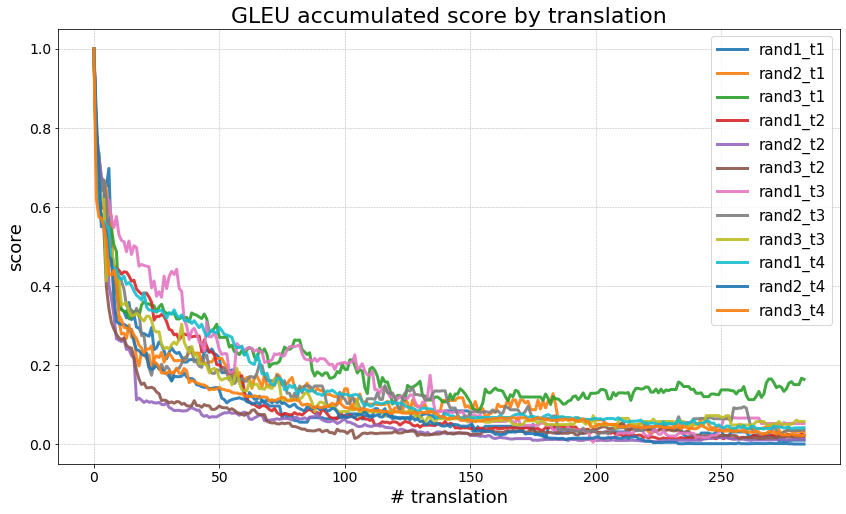

In [18]:
mean = res_all.plot('GLEU acc', fillBetween=False, showAll = True, showMean = False,showHarmonic=False , alphaAll = 0.9, title = 'GLEU accumulated score by translation')

>> RMSE: 0.03384329292791254
>> alpha: 0.48096


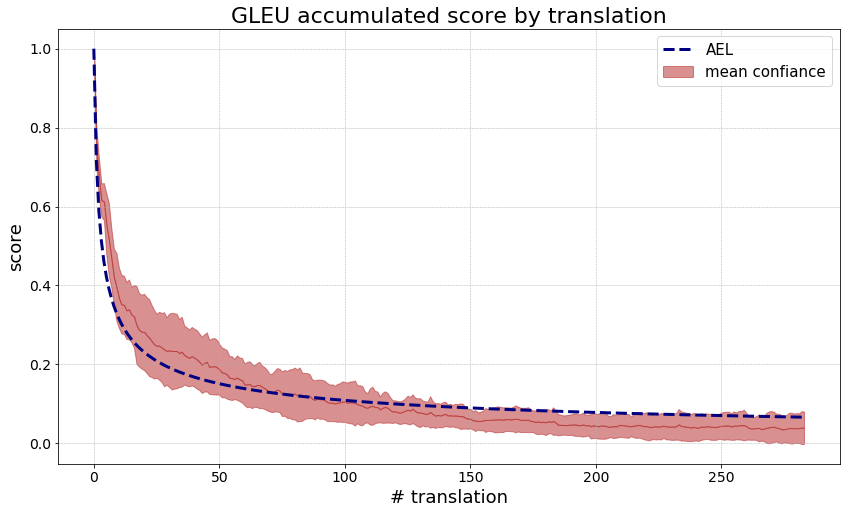

In [19]:
mean = res_all.plot('GLEU acc', fillBetween=True, showAll = False, showMean = False,showHarmonic=True , alphaAll = 0.9, title = 'GLEU accumulated score by translation')

>> alpha: 0.48096192384769537
>> R-squared: 0.9164487150748045


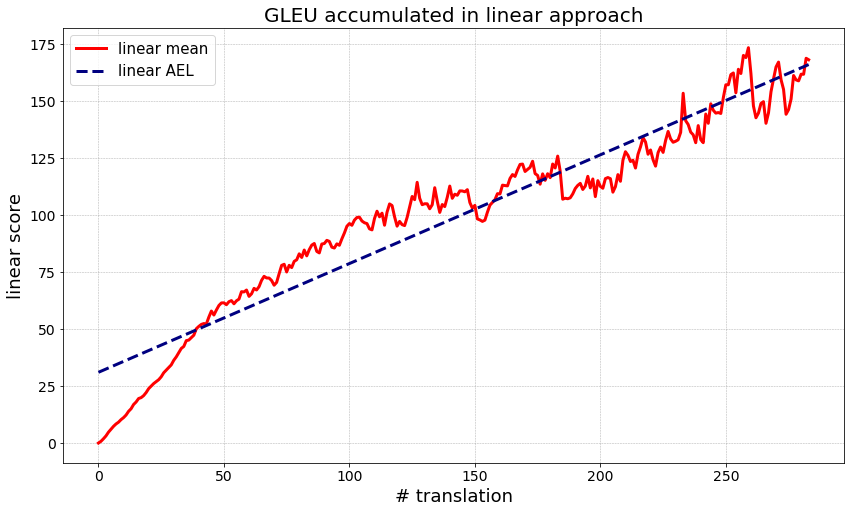

In [20]:
mean = res_all.plotRegression('GLEU acc')

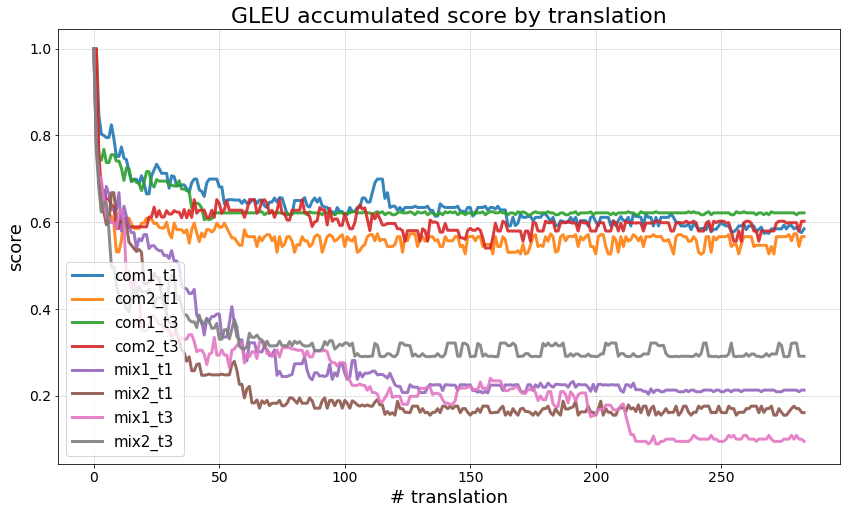

In [21]:
mean = reslr_all.plot('GLEU acc', fillBetween=False, showAll = True, showMean = False,showHarmonic=False , alphaAll = 0.9, title = 'GLEU accumulated score by translation')

>> RMSE: 0.022695419413058682
>> alpha: 0.29058


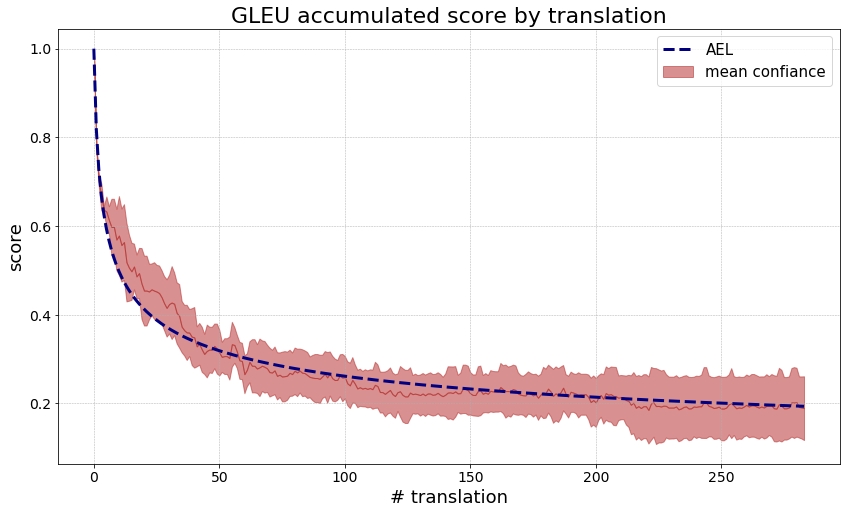

In [22]:
mean = resr_all.plot('GLEU acc', fillBetween=True, showAll = False, showMean = False,showHarmonic=True , alphaAll = 0.9, title = 'GLEU accumulated score by translation')

>> alpha: 0.2905811623246493
>> R-squared: 0.9937312691706184


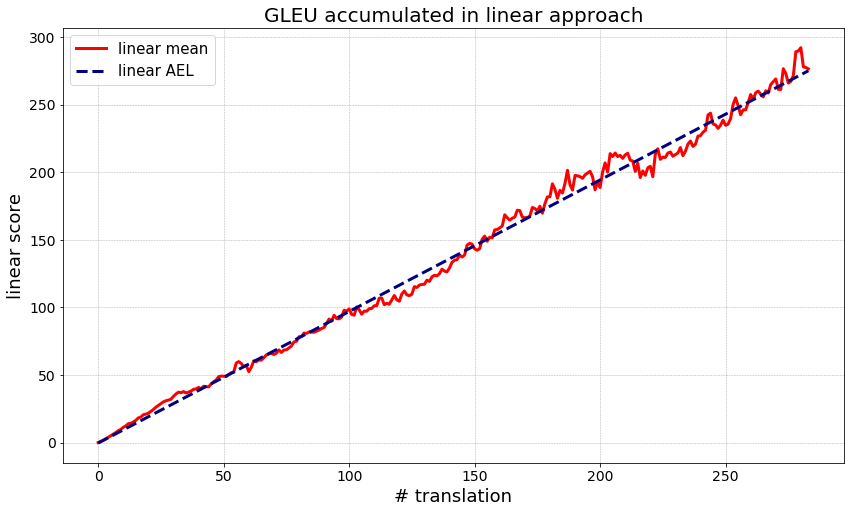

In [23]:
mean = resr_all.plotRegression('GLEU acc')

>> RMSE: 0.040689389371474455
>> alpha: 0.11022


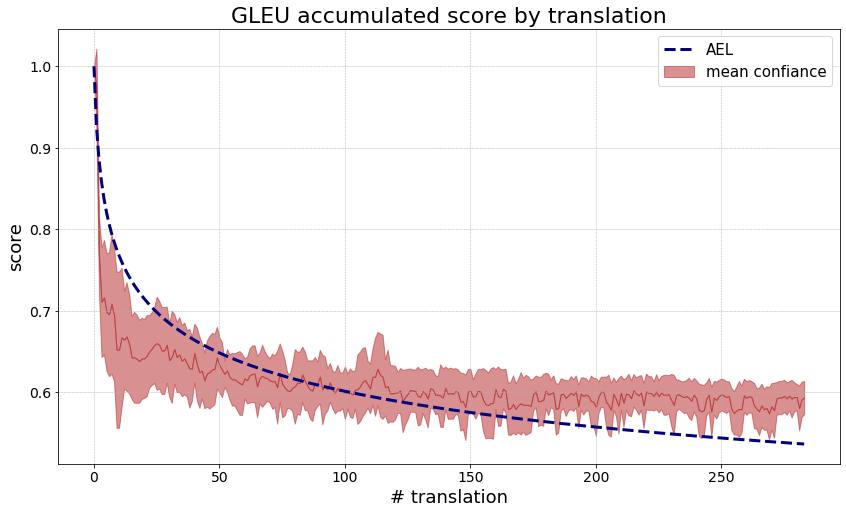

In [24]:
mean = resl_all.plot('GLEU acc', fillBetween=True, showAll = False, showMean = False,showHarmonic=True , alphaAll = 0.9, title = 'GLEU accumulated score by translation')

>> alpha: 0.11022044088176353
>> R-squared: 0.9985573482591061


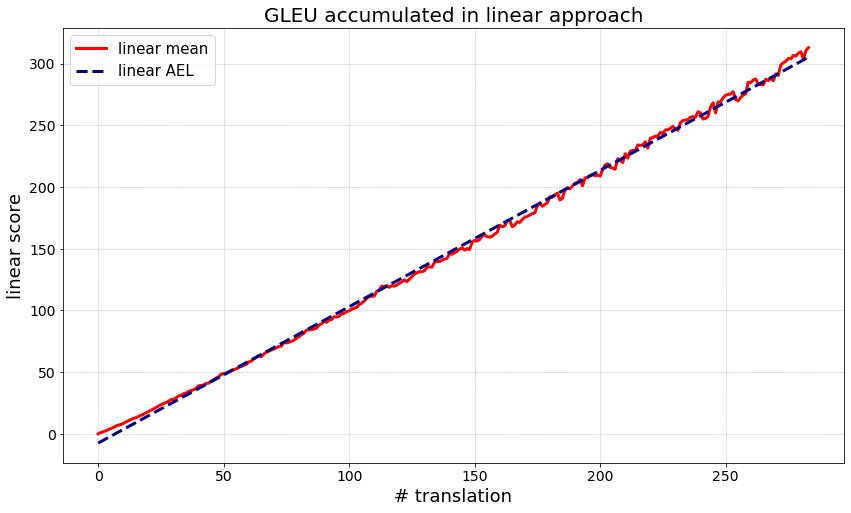

In [25]:
mean = resl_all.plotRegression('GLEU acc')

In [26]:
%%time

b1_t1 = Result('results/b1_t1.json')
b1_t2 = Result('results/b1_t2.json')
b2_t1 = Result('results/b2_t1.json')
b2_t2 = Result('results/b2_t2.json')
b3_t1 = Result('results/b3_t1.json')
b3_t2 = Result('results/b3_t2.json')

results = [b1_t1, b2_t1, b3_t1, b1_t2, b2_t2, b3_t2]
names = ['b1_t1', 'b2_t1', 'b3_t1', 'b1_t2', 'b2_t2', 'b3_t2']

res = Results(results, names)

res1 = Results(results[:3], names[:3])
res2 = Results(results[3:], names[3:])

FileNotFoundError: [Errno 2] No such file or directory: 'results/b1_t1.json'

In [27]:
base = Result('results/b3_t1.json')
data = base.df_.copy()

with open('output.txt', 'w', encoding = 'utf-8') as file:
    size = len(data)
    for row in range(size):
        file.write('Step ' + str(row) + '/' + str(size) + '\n')
        if row == 0:
            file.write(data['From lang'].values[row] + '\n')
        else:
            file.write(data['From lang'].values[row] + ' - ' + data['Lang'].values[row] + '\n')
        file.write('GLEUacc: ' + str(data['GLEU acc'].values[row]) + '\n')
        file.write('GLEUpap: ' + str(data['GLEU pap'].values[row]) + '\n')
        file.write('Size: ' + str(data['Size'].values[row]) + '\n')
        file.write('HarmonicMean: ' + str(res1.acc_harmonic_[row]) + '\n')
        file.write(data['Text en'].values[row] + '\n')
        file.write(data['Text origin'].values[row] + '\n')
        file.write('\n')

FileNotFoundError: [Errno 2] No such file or directory: 'results/b3_t1.json'

In [ ]:
_ = res.plot('Size', fillBetween=False, showAll = True, showMean = False, alphaAll = 0.9)

In [ ]:
_ = res1.plot('Size', fillBetween=True, showAll = False, showMean = False, alphaAll = 0.3, showHarmonic=False, ylabel = 'size', title = 'Size by translation')

In [ ]:
_ = res2.plot('Size', fillBetween=True, showAll = False, showMean = False, alphaAll = 0.3, showHarmonic=False, ylabel = 'size', title = 'Size by translation')

In [ ]:
_[283]

In [ ]:
mean = res.plotLogLog('Size')

In [ ]:
mean = res.plot('GLEU acc', fillBetween=False, showAll = True, showMean = False, alphaAll = 0.9, title = 'GLEU accumulated score by translation')

In [ ]:
mean = res.plot('GLEU acc', fillBetween=True, showAll = False, showMean = False,showHarmonic=True , alphaAll = 0.9, title = 'GLEU accumulated score by translation')

In [ ]:
mean = res.plot('GLEU acc', fillBetween=True, showAll = False, showMean = False, showHarmonic = True, title = 'Empirical-Teorichal comparison')

In [ ]:
mean = res.plotRegression('GLEU acc')

In [ ]:
mean = res.plotLogLog('GLEU acc')

In [ ]:
mean = res1.plot('Size', fillBetween=True, showAll = True, showMean = False, alphaAll = 0.9)

In [ ]:
mean = res1.plot('GLEU acc', fillBetween=True, showAll = True)

In [ ]:
mean = res1.plot('GLEU acc', fillBetween=False, showAll = False, showHarmonic = True, title = 'Empirical-Teorichal comparison')

In [ ]:
mean = res1.plotRegression('GLEU acc')

In [ ]:
mean = res1.plotLogLog('GLEU acc')

In [ ]:
_ = res2.plot('Size', fillBetween=True, showAll = True, showMean = False, alphaAll = 0.9)

In [ ]:
mean = res2.plot('GLEU acc', fillBetween=True, showAll = True)

In [ ]:
mean = res2.plot('GLEU acc', fillBetween=False, showAll = False, showHarmonic = True, title = 'Empirical-Teorichal comparison')

In [ ]:
mean = res2.plotRegression('GLEU acc')

In [ ]:
mean = res2.plotLogLog('GLEU acc')

## Exploring l1, l2, r1, r2, t1 experiments

In [48]:
%%time

com1_t1 = Result('results/com1_t1.json', graphpap=True)
com2_t1 = Result('results/com2_t1.json', graphpap=True)
com1_t3 = Result('results/com1_t3.json', graphpap=True)
com2_t3 = Result('results/com2_t3.json', graphpap=True)
mix1_t1 = Result('results/mix1_t1.json', graphpap=True)
mix2_t1 = Result('results/mix2_t1.json', graphpap=True)
mix1_t3 = Result('results/mix1_t3.json', graphpap=True)
mix2_t3 = Result('results/mix2_t3.json', graphpap=True)

results = [com1_t1, com2_t1, com1_t3, com2_t3, mix1_t1, mix2_t1, mix1_t3, mix2_t3]
names = ['com1_t1', 'com2_t1', 'com1_t3', 'com2_t3', 'mix1_t1', 'mix2_t1', 'mix1_t3', 'mix2_t3']

res_l_r = Results(results, names)
res_l = Results(results[:4], names[:4])
res_r = Results(results[4:], names[4:])

CPU times: user 8.16 s, sys: 15.7 ms, total: 8.18 s
Wall time: 8.28 s


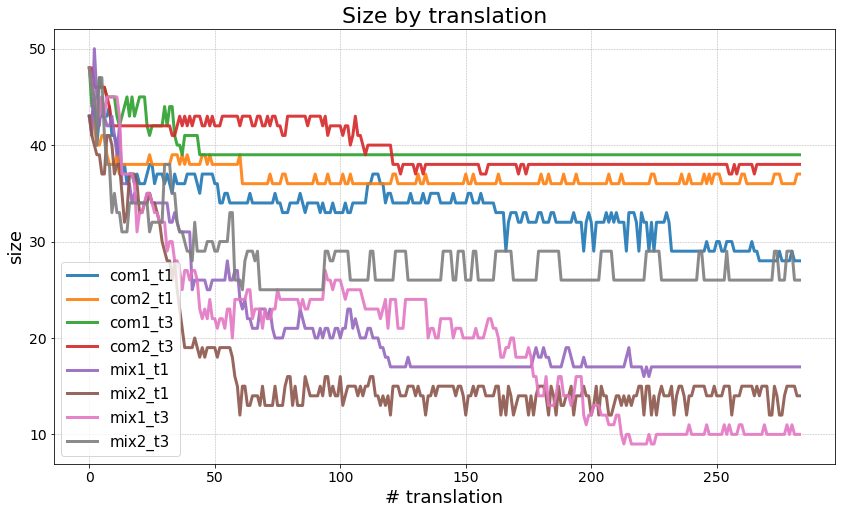

In [49]:
mean = res_l_r.plot('Size', fillBetween=False, showAll = True, showHarmonic = False, showMean = False, alphaAll = 0.9, ylabel = 'size', title = 'Size by translation')

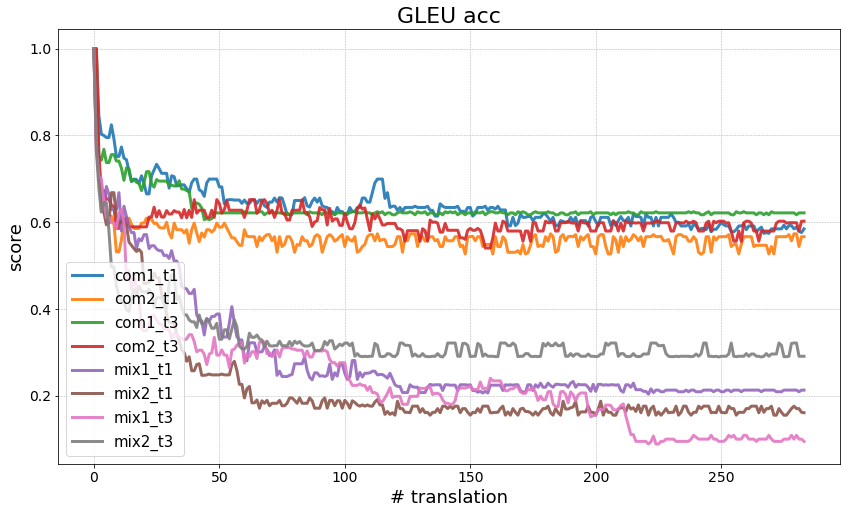

In [50]:
mean = res_l_r.plot('GLEU acc', fillBetween=False, showAll = True, showHarmonic = False, showMean = False, alphaAll = 0.9)

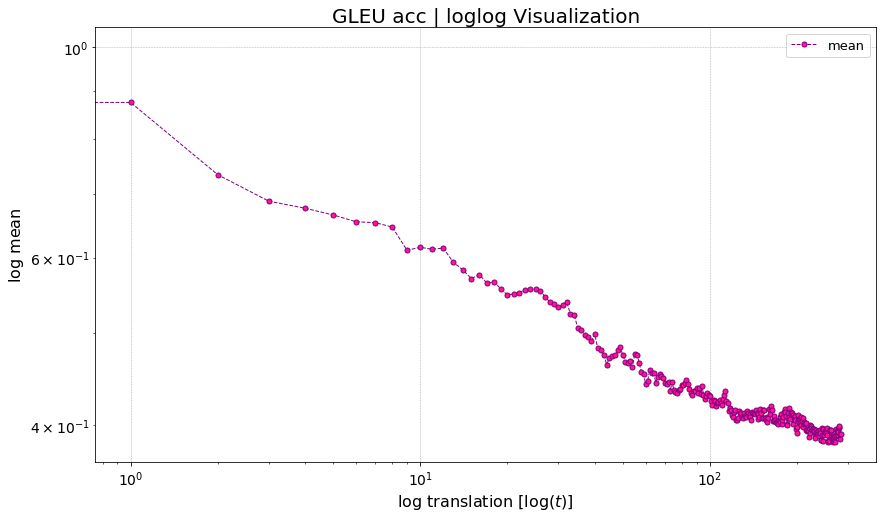

In [51]:
mean = res_l_r.plotLogLog('GLEU acc')

>> RMSE: 0.040689389371474455
>> alpha: 0.11022


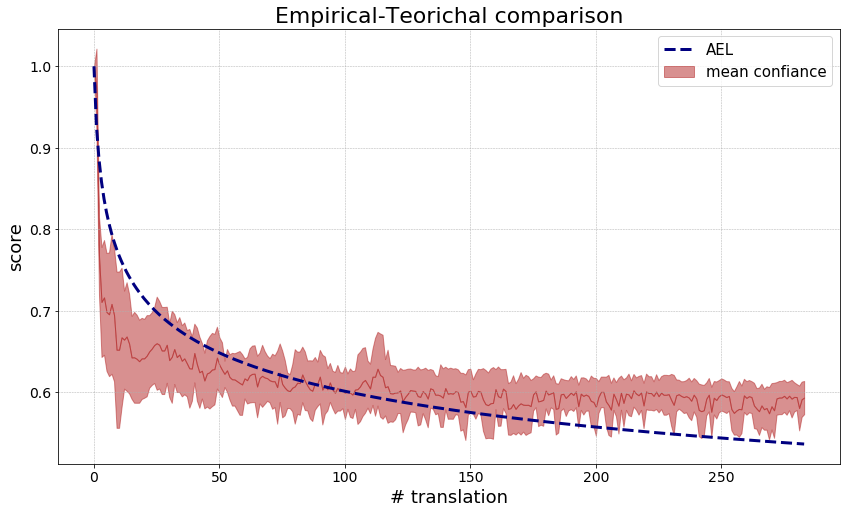

In [52]:
mean = res_l.plot('GLEU acc', fillBetween=True, showAll = False, showHarmonic = True, showMean = False, alphaAll = 0.9, title = 'Empirical-Teorichal comparison')

>> alpha: 0.11022044088176353
>> R-squared: 0.9985573482591061


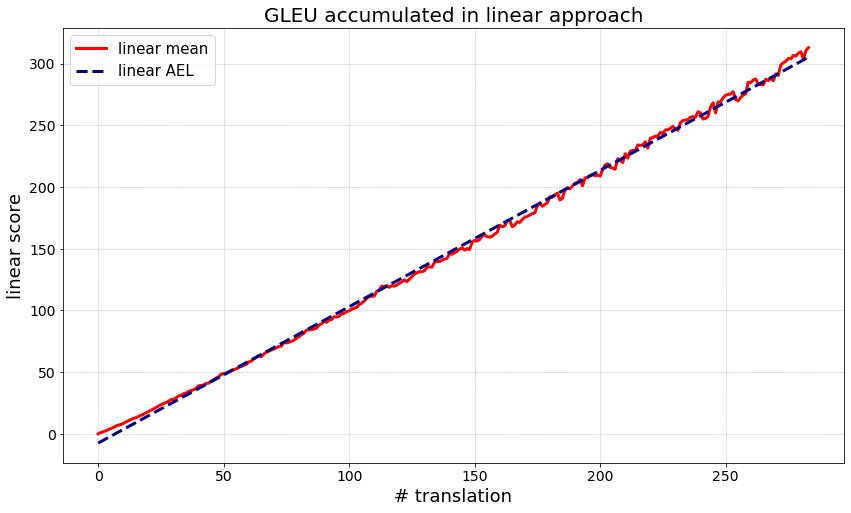

In [53]:
_ = res_l.plotRegression('GLEU acc')

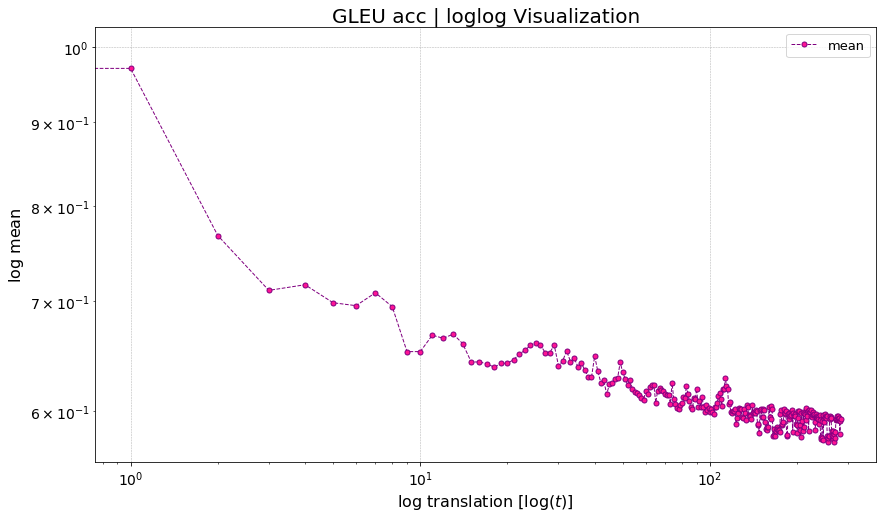

In [54]:
mean = res_l.plotLogLog('GLEU acc')

>> RMSE: 0.022695419413058682
>> alpha: 0.29058


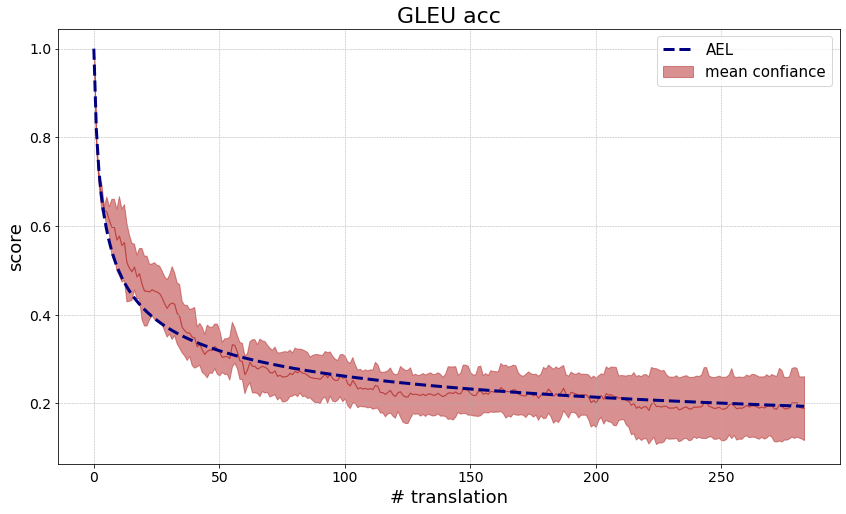

In [55]:
mean = res_r.plot('GLEU acc', fillBetween=True, showAll = False, showHarmonic = True, showMean = False, alphaAll = 0.9)

>> alpha: 0.2905811623246493
>> R-squared: 0.9937312691706184


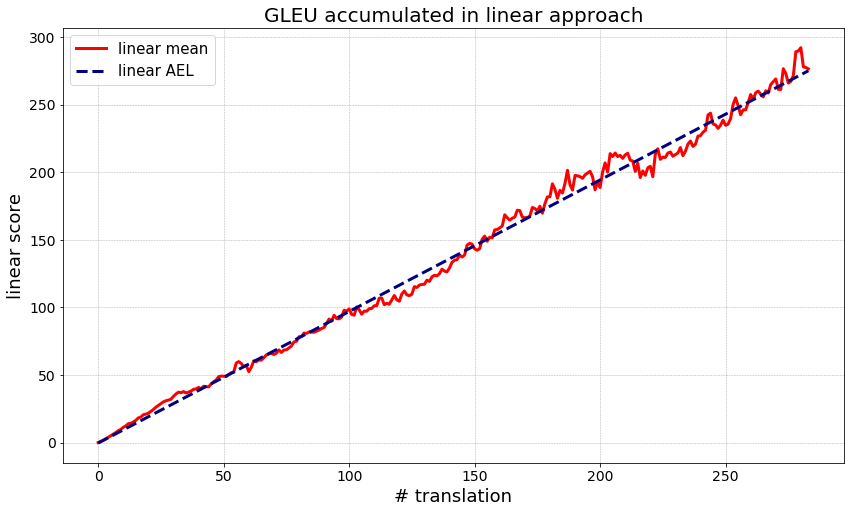

In [56]:
_ = res_r.plotRegression('GLEU acc')

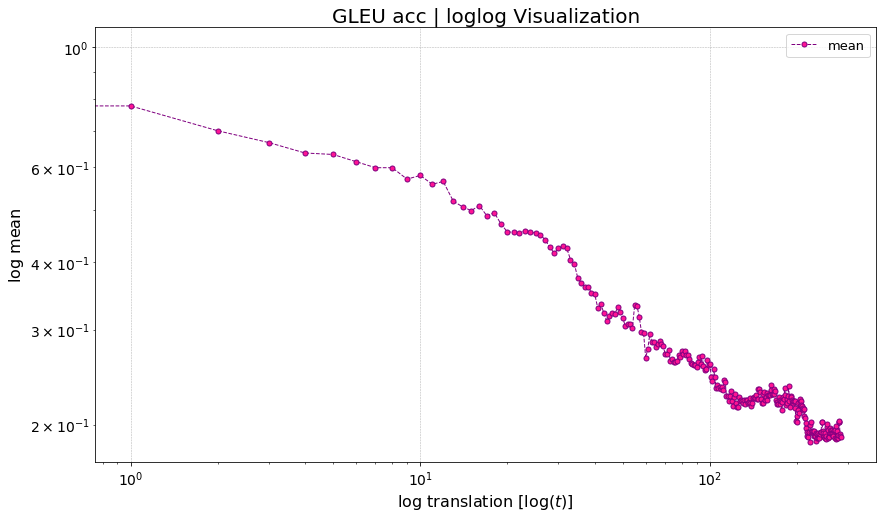

In [57]:
mean = res_r.plotLogLog('GLEU acc')

In [126]:
auxcom1_t1 = res_l_r.res['com1_t1'].graph_pap_.copy()
auxcom2_t1 = res_l_r.res['com2_t1'].graph_pap_.copy()
auxcom1_t3 = res_l_r.res['com1_t3'].graph_pap_.copy()
auxcom2_t3 = res_l_r.res['com2_t3'].graph_pap_.copy()
auxmix1_t1 = res_l_r.res['mix1_t1'].graph_pap_.copy()
auxmix2_t1 = res_l_r.res['mix2_t1'].graph_pap_.copy()
auxmix1_t3 = res_l_r.res['mix1_t3'].graph_pap_.copy()
auxmix2_t3 = res_l_r.res['mix2_t3'].graph_pap_.copy()

auxcom2_t1 = auxcom2_t1.drop(['Portuguese', 'English'], axis = 1)
auxcom2_t1 = auxcom2_t1.drop(['Portuguese'], axis = 0)
auxcom2_t3 = auxcom2_t3.drop(['English'], axis = 1)
auxcom1_t1 = auxcom1_t1.drop('English', axis = 1)
auxcom1_t3 = auxcom1_t3.drop('English', axis = 1)
auxmix1_t1 = auxmix1_t1.drop('English', axis = 1)
auxmix1_t3 = auxmix1_t3.drop('English', axis = 1)
auxmix2_t1 = auxmix2_t1.drop(['Portuguese', 'English'], axis = 1)
auxmix2_t1 = auxmix2_t1.drop(['Portuguese'], axis = 0)
auxmix2_t3 = auxmix2_t3.drop('English', axis = 1)

In [127]:
auxmix1_t1

,Portuguese,Chinese (Traditional),Russian,Hindi,Kurdish,Finnish
from \ to,,,,,,
Portuguese,1.000000,0.904299,0.932418,0.899611,0.848802,0.867708
Chinese (Traditional),0.932351,1.000000,0.914081,0.924919,0.854834,0.848203
Russian,0.928560,0.912834,1.000000,0.964557,0.877660,0.936921
Hindi,0.922138,0.890672,0.957509,1.000000,0.869015,0.886161
Kurdish,0.901359,0.915859,0.957218,0.909078,1.000000,0.903949
English,0.913019,0.945439,0.928399,0.973799,0.905326,0.876094
Finnish,0.947350,0.883027,0.915651,0.884775,0.871037,1.000000


In [128]:
auxcom1_t1 = prepareCorr(auxcom1_t1, 'l1_t1', dropEnglish = False)
auxcom2_t1 = prepareCorr(auxcom2_t1, 'l2_t1', dropEnglish = False)
auxcom1_t3 = prepareCorr(auxcom1_t3, 'l1_t3', dropEnglish = False)
auxcom2_t3 = prepareCorr(auxcom2_t3, 'l2_t3', dropEnglish = False)
auxmix1_t1 = prepareCorr(auxmix1_t1, 'r1_t1', dropEnglish = False)
auxmix2_t1 = prepareCorr(auxmix2_t1, 'r2_t1', dropEnglish = False)
auxmix1_t3 = prepareCorr(auxmix1_t3, 'r1_t3', dropEnglish = False)
auxmix2_t3 = prepareCorr(auxmix2_t3, 'r2_t3', dropEnglish = False)

In [152]:
print('Mean Scores:')
print('>> l1: {0:1.4f}'.format(meanCorr((auxcom1_t1 + auxcom1_t3)/2)))
print('>> l2: {0:1.4f}'.format(meanCorr((auxcom2_t1 + auxcom2_t3)/2)))
print('>> r1: {0:1.4f}'.format(meanCorr((auxmix1_t1 + auxmix1_t3)/2)))
print('>> r2: {0:1.4f}'.format(meanCorr((auxmix2_t1 + auxmix2_t3)/2)))

size = (13, 11)

Mean Scores:
>> l1: 0.9658
>> l2: 0.9489
>> r1: 0.8995
>> r2: 0.9018


In [171]:
def remapRows(df):
    cols = df.columns
    newdf = df.loc['English']
    for col in cols:
        newdf = pd.concat((newdf, df.loc[col]), axis = 1)
    return newdf.T

In [159]:
type(a)

pandas.core.frame.DataFrame

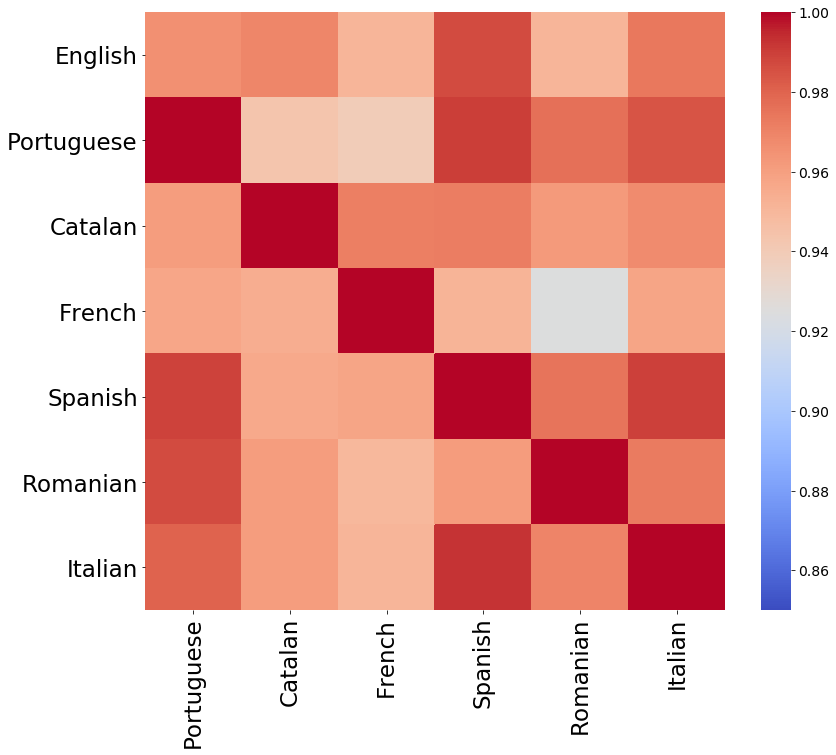

In [199]:
plt.figure(figsize=(size))
plt.xticks(fontsize = 23)
plt.yticks(fontsize = 23)
sns.heatmap(remapRows(auxcom1_t1 + auxcom1_t3)/2, vmax = 1, vmin = 0.85, cmap = 'coolwarm')

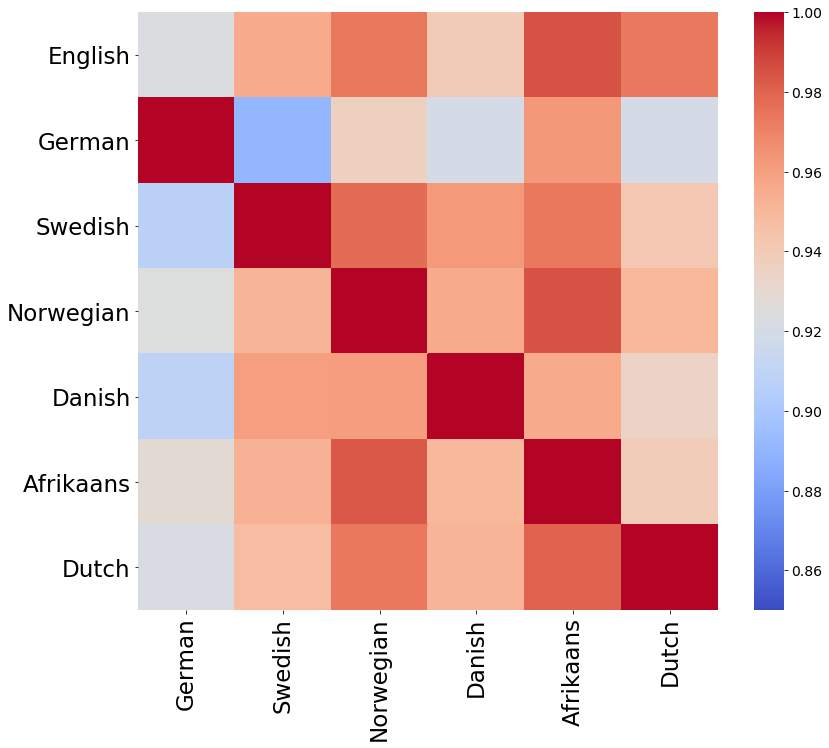

In [200]:
plt.figure(figsize=(size))
plt.xticks(fontsize = 23)
plt.yticks(fontsize = 23)
sns.heatmap(remapRows(auxcom2_t1 + auxcom2_t3)/2, vmax = 1, vmin = 0.85, cmap = 'coolwarm')

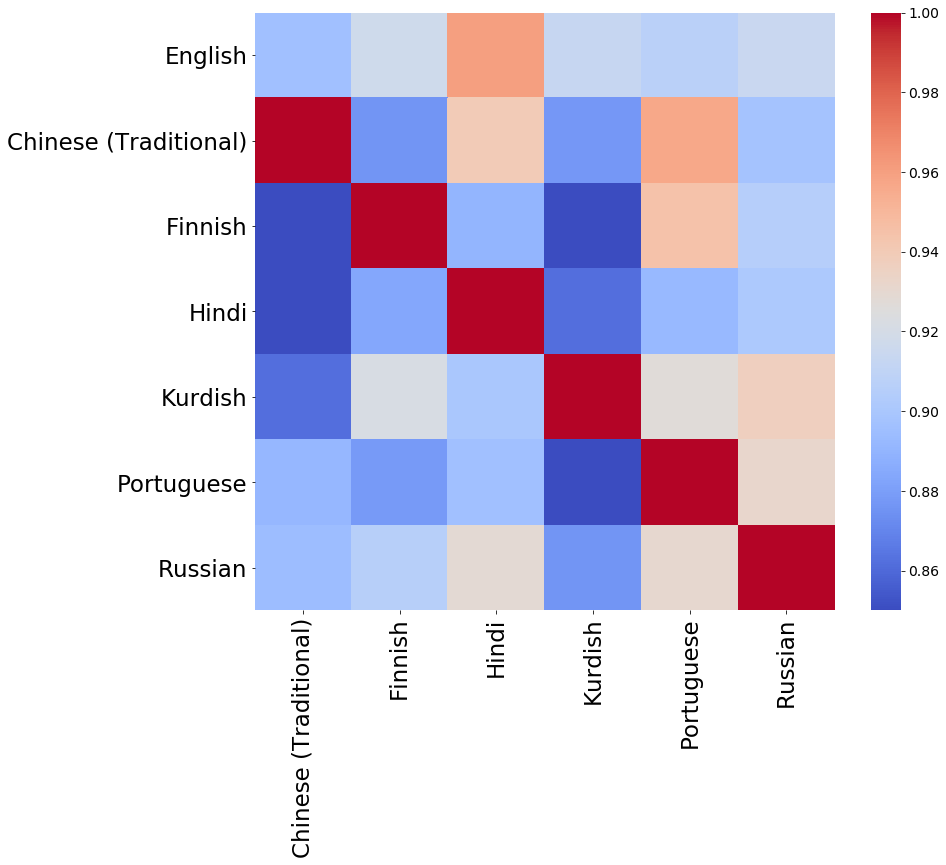

In [201]:
plt.figure(figsize=(size))
plt.xticks(fontsize = 23)
plt.yticks(fontsize = 23)
sns.heatmap(remapRows(auxmix1_t1 + auxmix1_t3)/2, vmax = 1, vmin = 0.85, cmap = 'coolwarm')

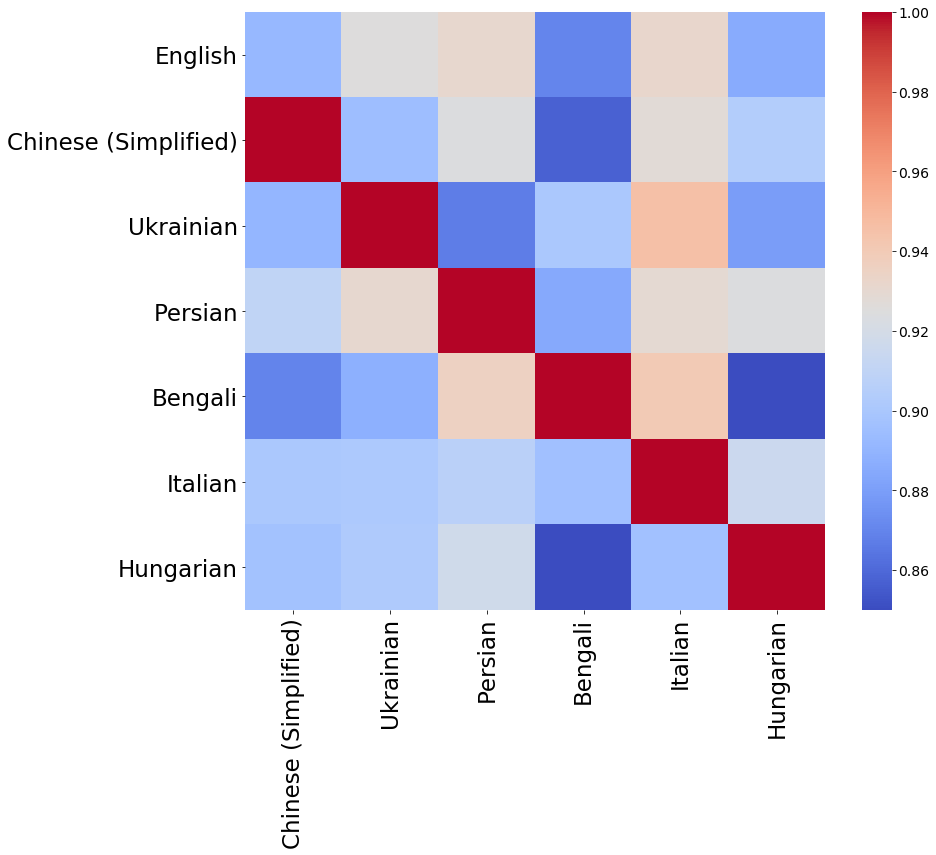

In [202]:
plt.figure(figsize=(size))
plt.xticks(fontsize = 23)
plt.yticks(fontsize = 23)
sns.heatmap(remapRows(auxmix2_t1 + auxmix2_t3)/2, vmax = 1, vmin = 0.85, cmap = 'coolwarm')

In [157]:
from sklearn.preprocessing import StandardScaler

In [62]:
def scaleWeigths(corrmat, scale = 10):
    
    '''
    Scale corrmat weigths
    '''
    scaler = StandardScaler()
    

    corrmat_scaled = scaler.fit_transform(corrmat)
    
    min_value = corrmat_scaled.min()
    corrmat_scaled += abs(min_value)
    
    max_value = corrmat_scaled.max()
    corrmat_scaled *= (scale / max_value)

    #corrmat_scaled += 0.000001
    #corrmat_scaled = np.log(corrmat_scaled)


    corrmat_scaled = pd.DataFrame(corrmat_scaled)

    corrmat_scaled.columns = corrmat.columns
    corrmat_scaled.index = corrmat.index
    
    return corrmat_scaled

In [63]:
import networkx as nx

def getCorrTuple(corrmat, auto = False):
    
    '''
    Get list of tuple (lang1, lang2, weigth) from corrmat
    '''
    
    tuples = []
    for lang1 in corrmat.index:
        for lang2 in corrmat.columns:
            
            # skip same language if auto is False
            if lang1 == lang2 and not auto:
                continue
            tupl = (lang1, lang2, corrmat.loc[lang1, lang2])
            tuples.append(tupl)
            del tupl
            
    return tuples

def corrToGraph(corrmat):
    
    '''
    Transform corrmat into Graph from networkx
    '''
    
    G = nx.DiGraph()
    G.add_nodes_from(corrmat.index)
    
    tuples = getCorrTuple(corrmat)
    G.add_weighted_edges_from(tuples)
    
    return G


In [64]:
data = scaleWeigths(auxl2)

NameError: name 'auxl2' is not defined

In [ ]:
G = corrToGraph(data)

In [ ]:
data

In [ ]:
G.nodes

In [ ]:
def plotGraph(G):
    
    f, ax = plt.subplots(1,1, figsize=(10.6,10.6))

    positions = [(0.1,6.2), (1.1,2.0), (2.8,9.7), (5.0,0.1), (7.1,9.6), (8.9,2.0), (9.8,6.2)]

    pos = {}
    for i, node in enumerate(G.nodes):
        pos[node] = positions[i]

    weights = [G[u][v]['weight'] for u,v in G.edges]
    nx.draw_networkx_nodes(G, pos = pos, nodes=G.nodes, node_color = 'deeppink')
    nx.draw_networkx_edges(G, pos = pos, edges=G.edges, width = weights, arrowstyle = '->')

    pos_higher = {}
    y_off = 0.3  # offset on the y axis

    for k, v in pos.items():
        pos_higher[k] = (v[0], v[1]+y_off)
        
    nx.draw_networkx_labels(G,pos = pos_higher, label = G.nodes, font_size=16)

In [ ]:
plotGraph(G)

In [ ]:
def rescaledGraph(corrmat):
    '''
    Scale corrmat weigths
    '''
    scaler = StandardScaler()
    corrmat_scaled = scaler.fit_transform(corrmat)
    
    min_value = corrmat_scaled.min()
    corrmat_scaled += abs(min_value) + 0.000001
    corrmat_scaled = -np.log(corrmat_scaled)


    corrmat_scaled = pd.DataFrame(corrmat_scaled)
    corrmat_scaled.columns = corrmat.columns
    corrmat_scaled.index = corrmat.index
    
    G = corrToGraph(corrmat_scaled)
    
    return G

In [ ]:
G_for_path = rescaledGraph(data)

In [ ]:
paths = []
for from_lang in data.index:
    for to_lang in data.columns:
        if from_lang == to_lang:
            continue
        step = [from_lang, to_lang]
        path = nx.shortest_path(G_for_path, from_lang, to_lang)
        paths.append([step, path])
        print(step == path)

## Exploring l1, l2, m1, m2, b1, b2, b3, t1 experiments

In [ ]:
%%time

results = [l1_t1, l2_t1, m1_t1, m2_t1, b1_t1, b2_t1, b3_t1]
names = ['l1_t1', 'l2_t1', 'm1_t1', 'm2_t1', 'b1_t1', 'b2_t1', 'b3_t1']

res_t = Results(results, names)
res_tm = Results(results[2:], names[2:])

In [ ]:
_ = res_t.plot('GLEU acc', showMean = False, alphaAll = 0.9)

In [ ]:
mean = res_t.plot('GLEU acc', showMean = False, alphaAll = 0.9, showAll=False, showHarmonic=True, fillBetween=True)

In [ ]:
_ = res_t.plotRegression('GLEU acc')

In [ ]:
mean = res_t.plotLogLog('GLEU acc')

In [ ]:
_ = res_tm.plot('GLEU acc', showMean = False, alphaAll = 0.9, fillBetween=True)

In [ ]:
_ = res_tm.plot('GLEU acc', showMean = False, alphaAll = 0.9, fillBetween=True, showAll = False, showHarmonic=True)

In [ ]:
mean = res_tm.plotRegression('GLEU acc')

In [ ]:
mean = res_tm.plotLogLog('GLEU acc')